<a href="https://colab.research.google.com/github/Oshada-Kasun/Automated-Object-Detection-using-YOLOv3/blob/main/Oshada_Automated_Object_Detection_using_YOLOv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Object Detection using YOLOv3.
This project is about object detection using the very powerful YOLO model. Many of the ideas in this notebook are described in the two YOLO papers: Redmon et al., 2016 and Redmon and Farhadi, 2016.

And also to to use a pre-trained model and fine tune it on new data.

# connecting colab to local Google Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create a Folder named 'YOLOv3' in Google Drive. 
## In here all code and data will be collected.

In [4]:
import os
os.chdir('YOLOv3')

### installing all requirements for the code base! 

In [5]:
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2/
#!pip install -r requirements-gpu.txt
!python setup.py install

fatal: destination path 'yolov3-tf2' already exists and is not an empty directory.
/content/drive/MyDrive/FourthBrain/Week_6/Oshada - Automated Object Detection using YOLOv3/YOLOv3/yolov3-tf2
running install
running bdist_egg
running egg_info
writing yolov3_tf2.egg-info/PKG-INFO
writing dependency_links to yolov3_tf2.egg-info/dependency_links.txt
writing top-level names to yolov3_tf2.egg-info/top_level.txt
adding license file 'LICENSE'
writing manifest file 'yolov3_tf2.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/yolov3_tf2
copying build/lib/yolov3_tf2/utils.py -> build/bdist.linux-x86_64/egg/yolov3_tf2
copying build/lib/yolov3_tf2/__init__.py -> build/bdist.linux-x86_64/egg/yolov3_tf2
copying build/lib/yolov3_tf2/dataset.py -> build/bdist.linux-x86_64/egg/yolov3_tf2
copying build/lib/yolov3_tf2/models.py -> build/bdist.linux-x86_64/egg/yolov

##### 2.  Check Tensorflow2 version

In [6]:
!ls

build		 data		  logs			tools
checkpoints	 detect.py	  output.jpg		train.py
colab_gpu.ipynb  detect_video.py  README.md		yolov3_tf2
conda-cpu.yml	 dist		  requirements-gpu.txt	yolov3_tf2.egg-info
conda-gpu.yml	 docs		  requirements.txt
convert.py	 LICENSE	  setup.py


In [7]:
import tensorflow as tf
tf.__version__

'2.8.0'

##### retrieve a Pretrained model weights.

In [8]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

--2022-04-03 14:29:32--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M  21.1MB/s    in 12s     

2022-04-03 14:29:45 (20.4 MB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]

Model: "yolov3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                      

## Problem Statement

Building an objector for a self-driving car use case, a critical component of this project, is a specific object detector, i.e cars only or pedestrians only etc. To collect data, mounted a camera to the hood (meaning the front) of the car, which takes pictures of the road ahead every few seconds while driving around. 

<center>
<video width="400" height="200" src="https://www.dropbox.com/s/804jv98ez3dllqd/road_video_compressed2.mp4?raw=1" type="video/mp4" controls>
</video>
</center>

<caption><center> Pictures taken from a car-mounted camera while driving around Silicon Valley. <br> Thank [drive.ai](htps://www.drive.ai/) for providing this dataset.
</center></caption>

Gathered all these images into a folder and have labelled them by drawing bounding boxes around every car you found. Here's an example of what bounding boxes look like.

<img src="https://www.dropbox.com/s/ljv8l2s15eizrlg/box_label.png?raw=1" style="width:500px;height:250;">
<caption><center> <u> **Figure 1** </u>: **Definition of a box**<br> </center></caption>

If we have 80 classes that we want the object detector to recognize, we can represent the class label $c$ either as an integer from 1 to 80, or as an 80-dimensional vector (with 80 numbers) one component of which is 1 and the rest of which are 0. In this notebook, we will use both representations, depending on which is more convenient for a particular step.  

In this Project, will learn how "You Only Look Once" (YOLOv3) performs object detection, and then apply it to object detection. YOLO models are training cost intensive, so will begin with pre-trained weights and then fine tune the training process for a particular object class only!

"You Only Look Once" (YOLO) is a popular algorithm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

### Model details

#### Inputs and outputs
- The **input** is a batch of images, and each image has the shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

#### Anchor Boxes
* Anchor boxes are chosen by exploring the training data to choose reasonable height/width ratios that represent the different classes.  For this project, 5 anchor boxes were chosen (to cover the 80 classes), and stored in the file './model_data/yolo_anchors.txt'
* The dimension for anchor boxes is the second to last dimension in the encoding: $(m, n_H,n_W,anchors,classes)$.
* The YOLO architecture is: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).  


#### Encoding
Let's look in greater detail at what this encoding represents. 

<img src="https://www.dropbox.com/s/bpzqt82newudmvk/architecture.png?raw=1" style="width:700px;height:400;">
<caption><center> <u> **Figure 2** </u>: **Encoding architecture for YOLO**<br> </center></caption>

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since we are using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, we will flatten the last two last dimensions of the shape (19, 19, 5, 85) encoding. So the output of the Deep CNN is (19, 19, 425).

<img src="https://www.dropbox.com/s/3rhn01o6ud2dv89/flatten.png?raw=1" style="width:700px;height:400;">
<caption><center> <u> **Figure 3** </u>: **Flattening the last two last dimensions**<br> </center></caption>

#### Class score

Now, for each box (of each cell) we will compute the following element-wise product and extract a probability that the box contains a certain class.  
The class score is $score_{c,i} = p_{c} \times c_{i}$: the probability that there is an object $p_{c}$ times the probability that the object is a certain class $c_{i}$.

<img src="https://www.dropbox.com/s/04y7n9h1w38mkmd/probability_extraction.png?raw=1" style="width:700px;height:400;">
<caption><center> <u> **Figure 4** </u>: **Find the class detected by each box**<br> </center></caption>

##### Example of figure 4
* In figure 4, let's say for box 1 (cell 1), the probability that an object exists is $p_{1}=0.60$.  So there's a 60% chance that an object exists in box 1 (cell 1).  
* The probability that the object is the class "category 3 (a car)" is $c_{3}=0.73$.  
* The score for box 1 and for category "3" is $score_{1,3}=0.60 \times 0.73 = 0.44$.  
* Let's say we calculate the score for all 80 classes in box 1, and find that the score for the car class (class 3) is the maximum.  So we'll assign the score 0.44 and class "3" to this box "1".

#### Visualizing classes
Here's one way to visualize what YOLO is predicting on an image:
- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across the 80 classes, one maximum for each of the 5 anchor boxes).
- Color that grid cell according to what object that grid cell considers the most likely.

Doing this results in this picture: 

<img src="https://www.dropbox.com/s/9r6cbdtsa947i6x/proba_map.png?raw=1" style="width:300px;height:300;">
<caption><center> <u> **Figure 5** </u>: Each one of the 19x19 grid cells is colored according to which class has the largest predicted probability in that cell.<br> </center></caption>

Note that this visualization isn't a core part of the YOLO algorithm itself for making predictions; it's just a nice way of visualizing an intermediate result of the algorithm. 


#### Visualizing bounding boxes
Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  

<img src="https://www.dropbox.com/s/x8abfjj9hgwu638/anchor_map.png?raw=1" style="width:200px;height:200;">
<caption><center> <u> **Figure 6** </u>: Each cell gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes. <br> </center></caption>

#### Non-Max suppression
In the figure above, we plotted only boxes for which the model had assigned a high probability, but this is still too many boxes. You'd like to reduce the algorithm's output to a much smaller number of detected objects.  

To do so, you'll use **non-max suppression**. Specifically, you'll carry out these steps: 
- Get rid of boxes with a low score (meaning, the box is not very confident about detecting a class; either due to the low probability of any object, or low probability of this particular class).
- Select only one box when several boxes overlap with each other and detect the same object.

applying the pre-trained detector on sample images.


### Load the libraries, model weights and images

In [9]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')

#Sample image is girl.png within data folder. 80 classes detection from MS COCO data set.
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Applying the pre-trained detector on a sample image from the yolov3-tf2/data folder

I0403 12:51:56.151204 139713372247936 <ipython-input-11-7436bda03a4d>:13] weights loaded
I0403 12:51:56.365921 139713372247936 <ipython-input-11-7436bda03a4d>:16] classes loaded
I0403 12:51:58.095156 139713372247936 <ipython-input-11-7436bda03a4d>:27] time: 1.5021045207977295
I0403 12:51:58.096603 139713372247936 <ipython-input-11-7436bda03a4d>:29] detections:
I0403 12:51:58.104074 139713372247936 <ipython-input-11-7436bda03a4d>:33] 	car, 0.9966800212860107, [0.26270664 0.34669653 0.40587908 0.5401914 ]
I0403 12:51:58.109374 139713372247936 <ipython-input-11-7436bda03a4d>:33] 	bus, 0.9951198101043701, [0.67014587 0.17855005 0.9937171  0.5290146 ]
I0403 12:51:58.114683 139713372247936 <ipython-input-11-7436bda03a4d>:33] 	person, 0.9870266914367676, [0.6138846 0.3450544 0.6877058 0.7753   ]
I0403 12:51:58.120565 139713372247936 <ipython-input-11-7436bda03a4d>:33] 	bus, 0.9826598763465881, [0.3228875  0.15145975 0.6138201  0.506682  ]
I0403 12:51:58.125718 139713372247936 <ipython-input-1

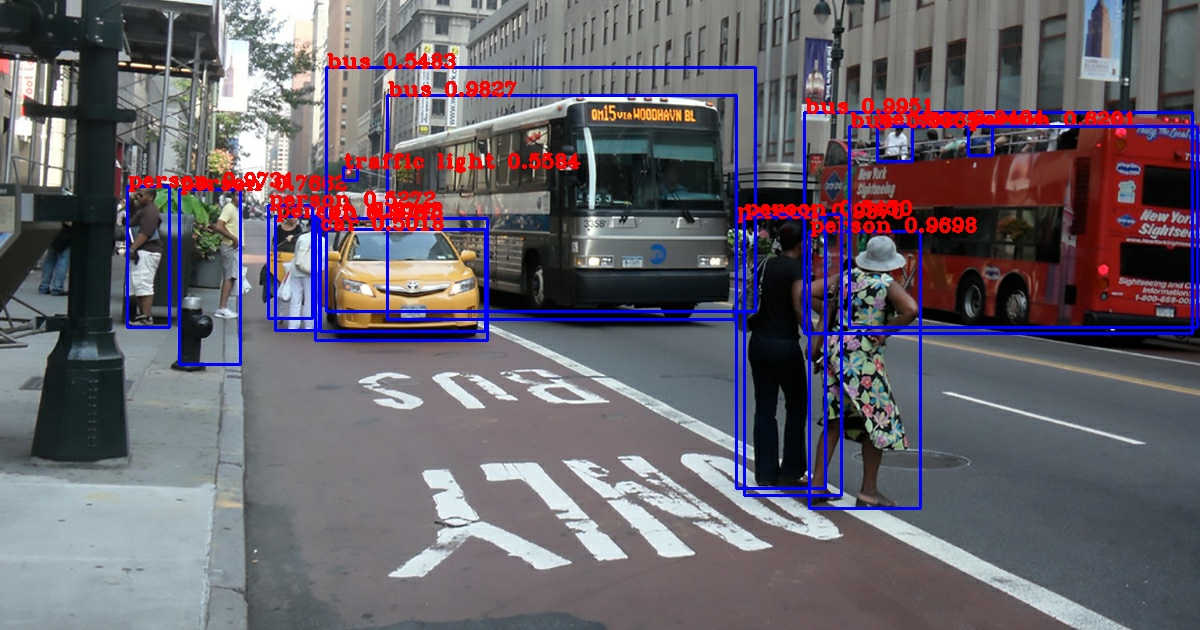

In [11]:
# Modify the name for all the images in the test_images folder
FLAGS.image = 'data/street.jpg'
#FLAGS.image = 'data/0004.jpg'
#FLAGS.image = 'data/giraffe.jpg'
#FLAGS.image = 'data/test.jpg'

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)
      
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

In [10]:
def apply_preTrained_detector(FLAGS):
  if FLAGS.tiny:
      yolo = YoloV3Tiny(classes=FLAGS.num_classes)
  else:
      yolo = YoloV3(classes=FLAGS.num_classes)
        
  yolo.load_weights(FLAGS.weights).expect_partial()
  logging.info('weights loaded')

  class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
  logging.info('classes loaded')

  img_raw = tf.image.decode_image(
      open(FLAGS.image, 'rb').read(), channels=3)

  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size)

  t1 = time.time()
  boxes, scores, classes, nums = yolo(img)
  t2 = time.time()
  logging.info('time: {}'.format(t2 - t1))

  logging.info('detections:')
  for i in range(nums[0]):
      logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                          np.array(scores[0][i]),
                                          np.array(boxes[0][i])))

  img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

  return img

In [11]:
from IPython.display import Image, display
def display_applied_boxes(FLAGS):
  img  = apply_preTrained_detector(FLAGS)
  display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

I0403 14:30:13.431046 140618262108032 <ipython-input-10-3bdb2ef1876c>:8] weights loaded
I0403 14:30:14.160616 140618262108032 <ipython-input-10-3bdb2ef1876c>:11] classes loaded
I0403 14:30:17.505096 140618262108032 <ipython-input-10-3bdb2ef1876c>:22] time: 2.58811354637146
I0403 14:30:17.506220 140618262108032 <ipython-input-10-3bdb2ef1876c>:24] detections:
I0403 14:30:17.512286 140618262108032 <ipython-input-10-3bdb2ef1876c>:28] 	car, 0.9966800212860107, [0.26270664 0.3466965  0.40587908 0.54019135]
I0403 14:30:17.515958 140618262108032 <ipython-input-10-3bdb2ef1876c>:28] 	bus, 0.9951198101043701, [0.67014587 0.17855003 0.9937171  0.5290146 ]
I0403 14:30:17.519640 140618262108032 <ipython-input-10-3bdb2ef1876c>:28] 	person, 0.9870266914367676, [0.6138846 0.3450544 0.6877058 0.7753   ]
I0403 14:30:17.523151 140618262108032 <ipython-input-10-3bdb2ef1876c>:28] 	bus, 0.9826598763465881, [0.3228875  0.15145977 0.6138201  0.506682  ]
I0403 14:30:17.526853 140618262108032 <ipython-input-10-3

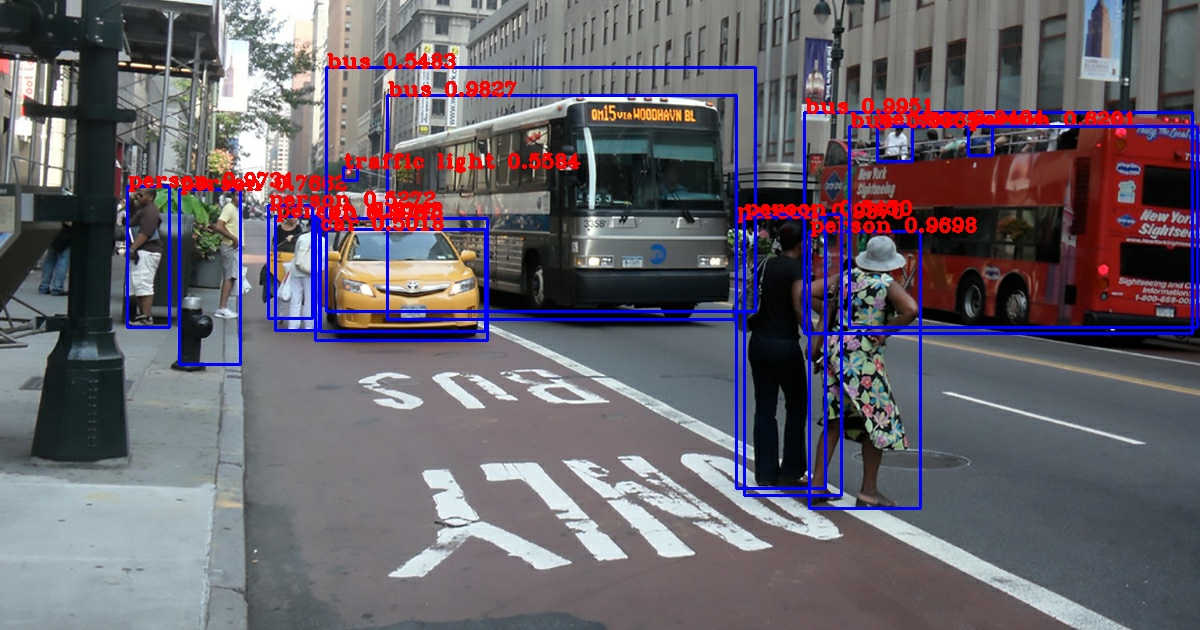

I0403 14:30:20.743780 140618262108032 <ipython-input-10-3bdb2ef1876c>:8] weights loaded
I0403 14:30:20.748147 140618262108032 <ipython-input-10-3bdb2ef1876c>:11] classes loaded
I0403 14:30:21.387150 140618262108032 <ipython-input-10-3bdb2ef1876c>:22] time: 0.10062026977539062
I0403 14:30:21.388600 140618262108032 <ipython-input-10-3bdb2ef1876c>:24] detections:
I0403 14:30:21.394463 140618262108032 <ipython-input-10-3bdb2ef1876c>:28] 	car, 0.9945942759513855, [0.08390436 0.4181878  0.17409328 0.47571415]
I0403 14:30:21.399167 140618262108032 <ipython-input-10-3bdb2ef1876c>:28] 	car, 0.9919449687004089, [0.00217112 0.45459333 0.09452537 0.57086265]
I0403 14:30:21.404208 140618262108032 <ipython-input-10-3bdb2ef1876c>:28] 	car, 0.9793890118598938, [0.30968887 0.39875886 0.4104424  0.45354083]
I0403 14:30:21.408842 140618262108032 <ipython-input-10-3bdb2ef1876c>:28] 	car, 0.9760374426841736, [0.4204707  0.38653278 0.50878394 0.4363724 ]
I0403 14:30:21.413933 140618262108032 <ipython-input-

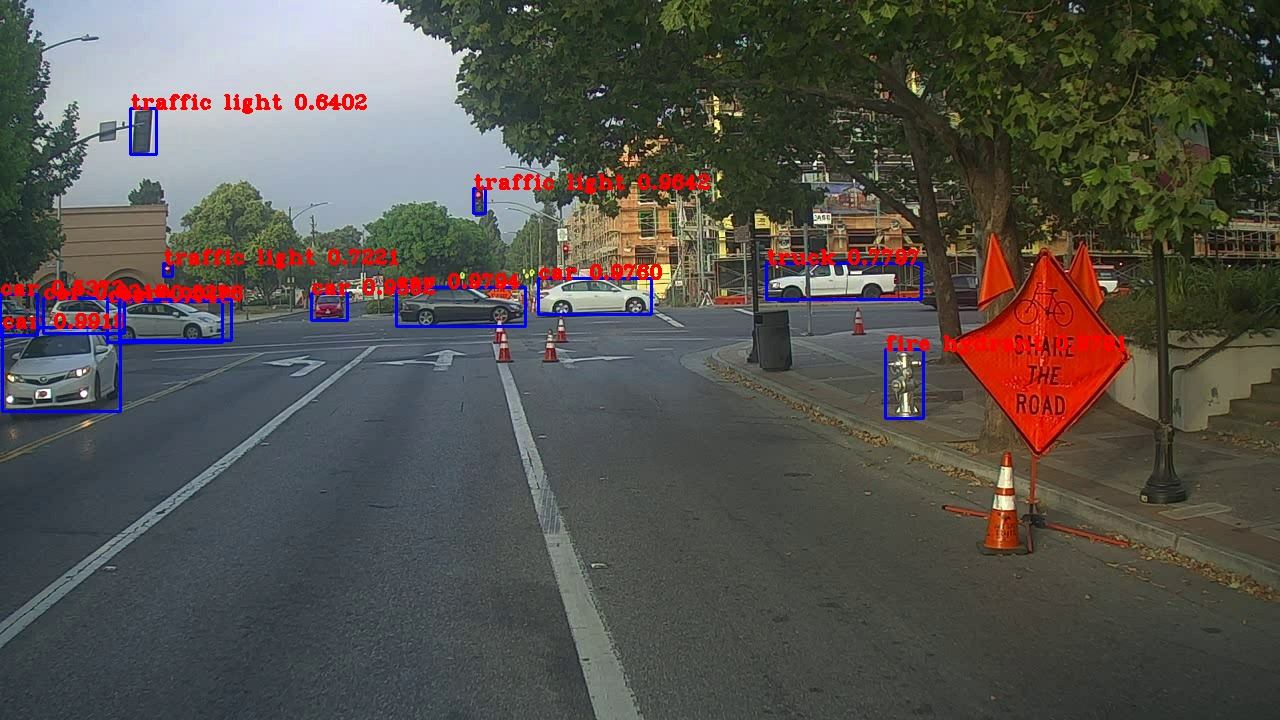

I0403 14:30:24.414034 140618262108032 <ipython-input-10-3bdb2ef1876c>:8] weights loaded
I0403 14:30:24.416509 140618262108032 <ipython-input-10-3bdb2ef1876c>:11] classes loaded
I0403 14:30:25.154123 140618262108032 <ipython-input-10-3bdb2ef1876c>:22] time: 0.10147333145141602
I0403 14:30:25.155258 140618262108032 <ipython-input-10-3bdb2ef1876c>:24] detections:
I0403 14:30:25.162781 140618262108032 <ipython-input-10-3bdb2ef1876c>:28] 	car, 0.9992826581001282, [0.27649012 0.4105447  0.59023607 0.896624  ]
I0403 14:30:25.167202 140618262108032 <ipython-input-10-3bdb2ef1876c>:28] 	car, 0.9985067844390869, [0.59527993 0.3980793  0.7218013  0.56224144]
I0403 14:30:25.170871 140618262108032 <ipython-input-10-3bdb2ef1876c>:28] 	car, 0.996269941329956, [0.7381854  0.44752878 1.0068752  0.9742908 ]
I0403 14:30:25.175179 140618262108032 <ipython-input-10-3bdb2ef1876c>:28] 	car, 0.9922270774841309, [0.7231026  0.40837514 0.82352275 0.5277095 ]
I0403 14:30:25.179021 140618262108032 <ipython-input-1

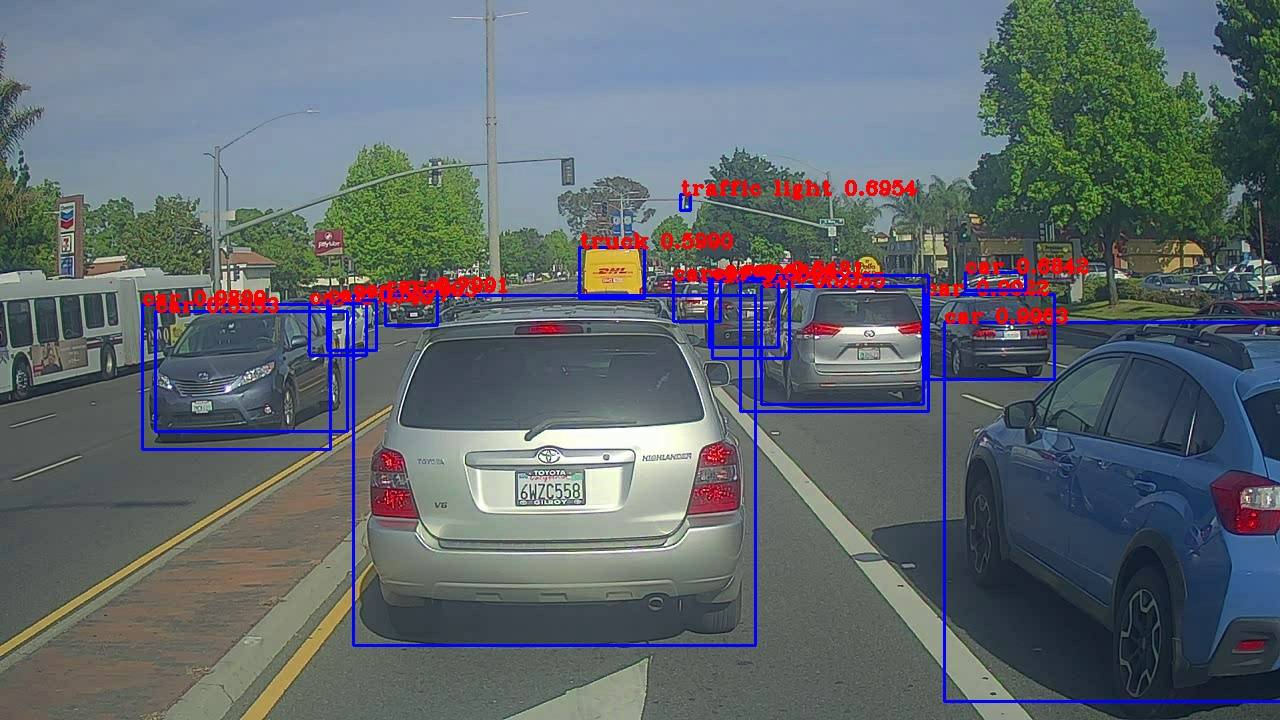

I0403 14:30:28.223929 140618262108032 <ipython-input-10-3bdb2ef1876c>:8] weights loaded
I0403 14:30:28.226560 140618262108032 <ipython-input-10-3bdb2ef1876c>:11] classes loaded
I0403 14:30:29.104234 140618262108032 <ipython-input-10-3bdb2ef1876c>:22] time: 0.09806680679321289
I0403 14:30:29.105313 140618262108032 <ipython-input-10-3bdb2ef1876c>:24] detections:
I0403 14:30:29.109695 140618262108032 <ipython-input-10-3bdb2ef1876c>:28] 	giraffe, 0.9978438019752502, [0.30420476 0.09656736 0.87990075 0.869931  ]
I0403 14:30:29.113222 140618262108032 <ipython-input-10-3bdb2ef1876c>:28] 	zebra, 0.8449259996414185, [0.52784646 0.400668   0.8689227  0.90139806]


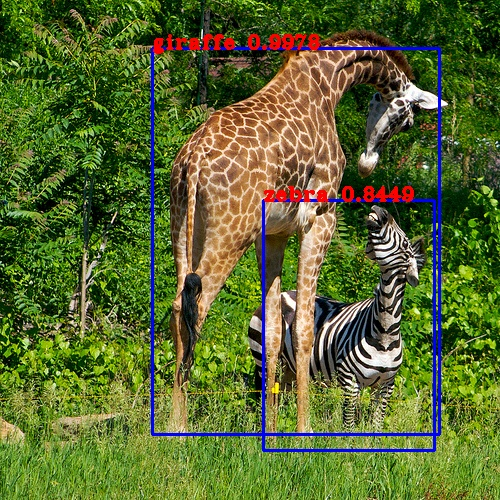

In [12]:
FLAGS.image = 'data/street.jpg'
display_applied_boxes(FLAGS)

FLAGS.image = 'data/0004.jpg'
display_applied_boxes(FLAGS)


FLAGS.image = 'data/test.jpg'
display_applied_boxes(FLAGS)

FLAGS.image = 'data/giraffe.jpg'
display_applied_boxes(FLAGS)

## retrain/fine tune the detector for additional images
Downloading the PASCAL VOC 2007 data set. (the dataset at https://www.kaggle.com/zaraks/pascal-voc-2007)

In [13]:
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar -O ./data/voc2007_raw.tar
!mkdir -p ./data/voc2007_raw
!tar -xf ./data/voc2007_raw.tar -C ./data/voc2007_raw

URL transformed to HTTPS due to an HSTS policy
--2022-04-03 14:30:42--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘./data/voc2007_raw.tar’

./data/voc2007_raw. 100%[===================>] 438.72M  22.3MB/s    in 21s     

2022-04-03 14:31:04 (21.2 MB/s) - ‘./data/voc2007_raw.tar’ saved [460032000/460032000]



## Next, use the voc2012.py file to split the above VOC 2007 data to training and validation

In [14]:
!python tools/voc2012.py \
  --data_dir './data/voc2007_raw/VOCdevkit/VOC2007' \
  --split train \
  --output_file ./data/voc_train.tfrecord

!python tools/voc2012.py \
  --data_dir './data/voc2007_raw/VOCdevkit/VOC2007' \
  --split val \
  --output_file ./data/voc_val.tfrecord

I0403 14:33:17.160039 140256062183296 voc2012.py:92] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
I0403 14:33:21.023088 140256062183296 voc2012.py:97] Image list loaded: 2501
100% 2501/2501 [00:07<00:00, 347.12it/s]
I0403 14:33:28.232993 140256062183296 voc2012.py:106] Done
I0403 14:33:31.632225 140497302005632 voc2012.py:92] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
I0403 14:33:36.725997 140497302005632 voc2012.py:97] Image list loaded: 2510
100% 2510/2510 [00:06<00:00, 382.42it/s]
I0403 14:33:43.294896 1

# Running the cell below for 5 times.

I0403 14:33:47.141710 140562674665344 visualize_dataset.py:22] classes loaded
2022-04-03 14:33:47.850222: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0403 14:33:50.579801 140562674665344 visualize_dataset.py:43] labels:
I0403 14:33:50.580592 140562674665344 visualize_dataset.py:47] 	bird, 1, [0.07       0.24024025 0.836      0.9159159 ]
I0403 14:33:51.362242 140562674665344 visualize_dataset.py:52] output saved to: ./output.jpg


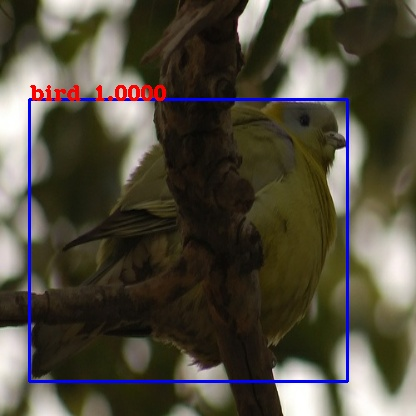

In [15]:
#Running this cell 5 times and displaing the output images.
!python tools/visualize_dataset.py --dataset ./data/voc_train.tfrecord --classes=./data/voc2012.names

from IPython.display import Image
Image(filename='./output.jpg')

I0403 14:33:54.741575 140475889735552 visualize_dataset.py:22] classes loaded
2022-04-03 14:33:55.442921: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0403 14:33:57.987055 140475889735552 visualize_dataset.py:43] labels:
I0403 14:33:57.987883 140475889735552 visualize_dataset.py:47] 	dog, 1, [0.078      0.24773414 0.704      0.9969789 ]
I0403 14:33:58.000390 140475889735552 visualize_dataset.py:52] output saved to: ./output.jpg


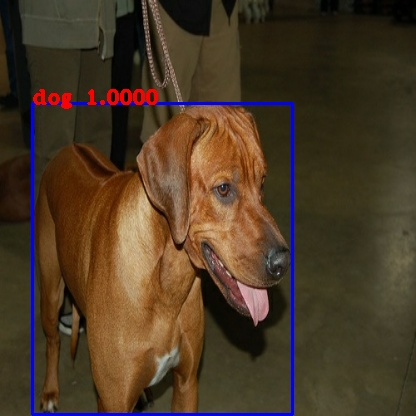

In [16]:
!python tools/visualize_dataset.py --dataset ./data/voc_train.tfrecord --classes=./data/voc2012.names

from IPython.display import Image
Image(filename='./output.jpg')

I0403 14:34:02.176115 139847764645760 visualize_dataset.py:22] classes loaded
2022-04-03 14:34:03.048849: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0403 14:34:05.522496 139847764645760 visualize_dataset.py:43] labels:
I0403 14:34:05.523294 139847764645760 visualize_dataset.py:47] 	motorbike, 1, [0.44       0.41066667 0.6        0.74666667]
I0403 14:34:05.534461 139847764645760 visualize_dataset.py:52] output saved to: ./output.jpg


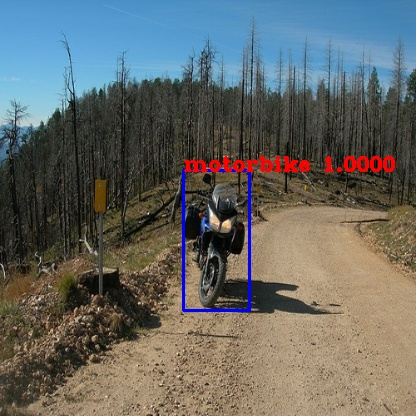

In [17]:
#Running this cell 5 times and displaing the output images.
!python tools/visualize_dataset.py --dataset ./data/voc_train.tfrecord --classes=./data/voc2012.names

from IPython.display import Image
Image(filename='./output.jpg')

I0403 14:34:09.078582 140661479425920 visualize_dataset.py:22] classes loaded
2022-04-03 14:34:09.802991: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0403 14:34:12.407280 140661479425920 visualize_dataset.py:43] labels:
I0403 14:34:12.408067 140661479425920 visualize_dataset.py:47] 	motorbike, 1, [0.186      0.42642644 0.716      1.        ]
I0403 14:34:12.408727 140661479425920 visualize_dataset.py:47] 	bicycle, 1, [0.58       0.44444445 0.702      0.5315315 ]
I0403 14:34:12.409342 140661479425920 visualize_dataset.py:47] 	person, 1, [0.208      0.22222222 0.516      0.9309309 ]
I0403 14:34:12.420063 140661479425920 visualize_dataset.py:52] output saved to: ./output.jpg


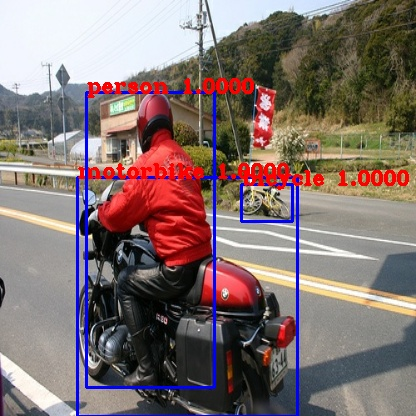

In [18]:
!python tools/visualize_dataset.py --dataset ./data/voc_train.tfrecord --classes=./data/voc2012.names

from IPython.display import Image
Image(filename='./output.jpg')

I0403 14:34:15.905668 139621388175232 visualize_dataset.py:22] classes loaded
2022-04-03 14:34:16.599490: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0403 14:34:19.066391 139621388175232 visualize_dataset.py:43] labels:
I0403 14:34:19.067207 139621388175232 visualize_dataset.py:47] 	car, 1, [0.18      0.3753754 0.674     0.6366366]
I0403 14:34:19.076826 139621388175232 visualize_dataset.py:52] output saved to: ./output.jpg


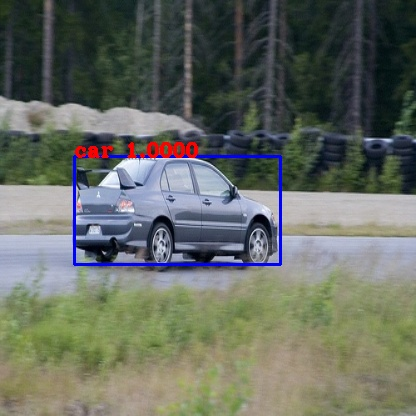

In [19]:
!python tools/visualize_dataset.py --dataset ./data/voc_train.tfrecord --classes=./data/voc2012.names

from IPython.display import Image
Image(filename='./output.jpg')

### Next retrainning the model using the PASCAL VOC train/validation images below.

In [20]:
!python train.py \
	--dataset ./data/voc_train.tfrecord \
	--val_dataset ./data/voc_val.tfrecord \
	--classes ./data/voc2012.names \
	--num_classes 20 \
	--mode fit --transfer darknet \
	--batch_size 16 \
	--epochs 3 \
	--weights ./checkpoints/yolov3.tf \
	--weights_num_classes 80 

2022-04-03 14:34:24.390375: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
Epoch 1/3
Instructions for updating:
Use fn_output_signature instead
W0403 14:34:34.368295 140016649082752 deprecation.py:547] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/util/deprecation.py:616: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead
2022-04-03 14:34:49.735248: W tensorflow/core/common_runtime/bfc_allocator.cc:343] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region t

### Applying the fine tuned weights on the images from test_images folder.


In [21]:
def applyFineTunedModel(imagePath):
  FLAGS.num_classes = 20
  FLAGS.classes = 'data/voc2012.names'
  FLAGS.weights = 'checkpoints/yolov3_train_3.tf'
  FLAGS.image = imagePath

  # Lower threshold due to insufficient training
  FLAGS.yolo_iou_threshold = 0.2
  FLAGS.yolo_score_threshold = 0.2

  if FLAGS.tiny:
      yolo = YoloV3Tiny(classes=FLAGS.num_classes)
  else:
      yolo = YoloV3(classes=FLAGS.num_classes)

  yolo.load_weights(FLAGS.weights).expect_partial()
  logging.info('weights loaded')

  class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
  logging.info('classes loaded')

  img_raw = tf.image.decode_image(
      open(FLAGS.image, 'rb').read(), channels=3)

  img = tf.expand_dims(img_raw, 0)
  img = transform_images(img, FLAGS.size)

  t1 = time.time()
  boxes, scores, classes, nums = yolo(img)
  t2 = time.time()
  logging.info('time: {}'.format(t2 - t1))

  logging.info('detections:')
  for i in range(nums[0]):
      logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                          np.array(scores[0][i]),
                                          np.array(boxes[0][i])))

  img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
  img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
  return img

In [22]:
from IPython.display import Image, display
def displayFineTunedModelResult(imagePath):
  img = applyFineTunedModel(imagePath)
  display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

I0403 14:42:48.173058 140618262108032 <ipython-input-21-be03c3b6b2ee>:17] weights loaded
I0403 14:42:48.176255 140618262108032 <ipython-input-21-be03c3b6b2ee>:20] classes loaded
I0403 14:42:48.296177 140618262108032 <ipython-input-21-be03c3b6b2ee>:31] time: 0.10526156425476074
I0403 14:42:48.297161 140618262108032 <ipython-input-21-be03c3b6b2ee>:33] detections:
I0403 14:42:48.301911 140618262108032 <ipython-input-21-be03c3b6b2ee>:37] 	car, 0.26665374636650085, [0.72077936 0.42770433 0.8475687  0.5365208 ]
I0403 14:42:48.305694 140618262108032 <ipython-input-21-be03c3b6b2ee>:37] 	car, 0.2593608498573303, [0.59428465 0.41553032 0.7422385  0.5443994 ]
I0403 14:42:48.309239 140618262108032 <ipython-input-21-be03c3b6b2ee>:37] 	car, 0.21881313621997833, [0.8290156 0.4782205 0.9568399 0.983883 ]


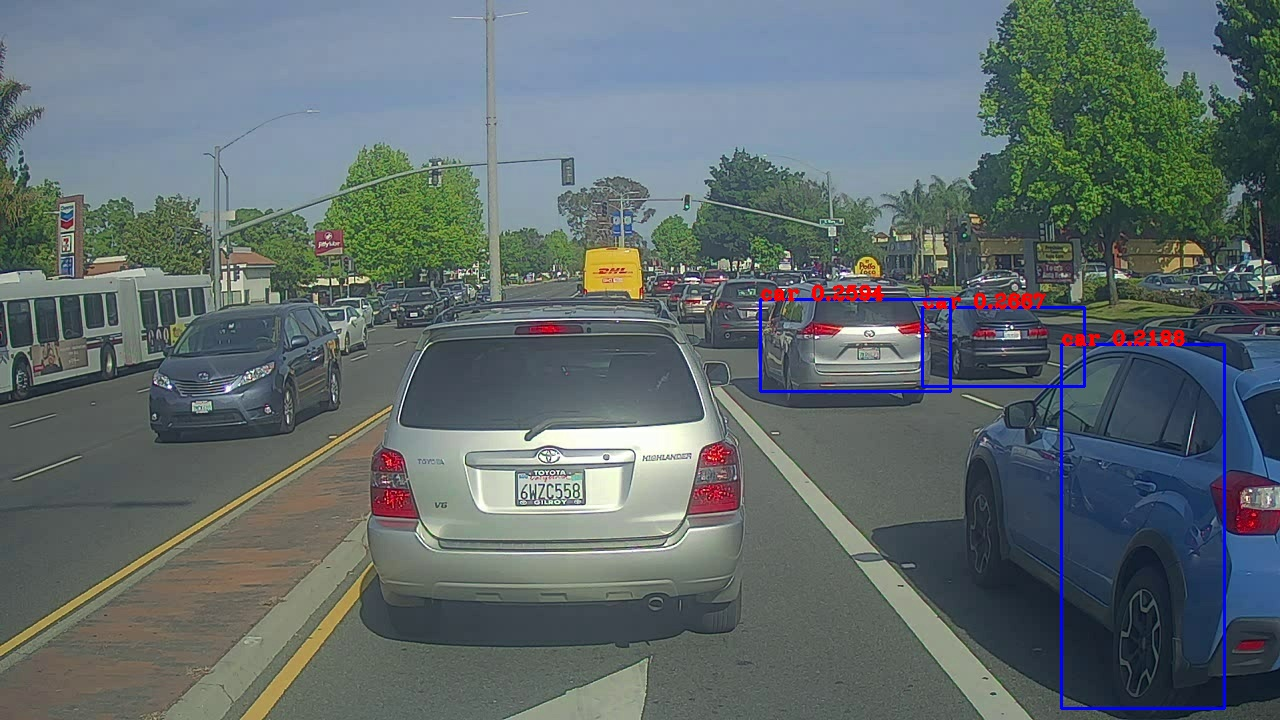

I0403 14:42:51.362681 140618262108032 <ipython-input-21-be03c3b6b2ee>:17] weights loaded
I0403 14:42:51.365128 140618262108032 <ipython-input-21-be03c3b6b2ee>:20] classes loaded
I0403 14:42:51.502016 140618262108032 <ipython-input-21-be03c3b6b2ee>:31] time: 0.09996891021728516
I0403 14:42:51.503019 140618262108032 <ipython-input-21-be03c3b6b2ee>:33] detections:
I0403 14:42:51.506825 140618262108032 <ipython-input-21-be03c3b6b2ee>:37] 	person, 0.3743450939655304, [0.6051273  0.25079766 0.6730022  0.78874815]
I0403 14:42:51.512402 140618262108032 <ipython-input-21-be03c3b6b2ee>:37] 	person, 0.3675124943256378, [0.67454445 0.2931104  0.75008655 0.8953247 ]


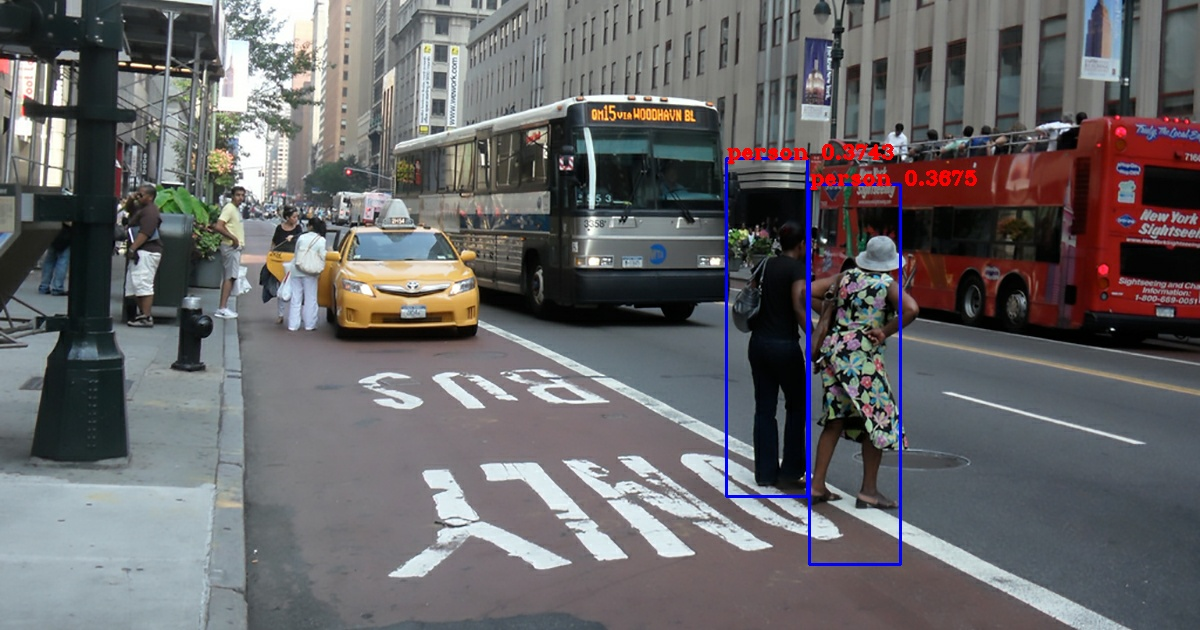

I0403 14:42:54.316118 140618262108032 <ipython-input-21-be03c3b6b2ee>:17] weights loaded
I0403 14:42:54.318641 140618262108032 <ipython-input-21-be03c3b6b2ee>:20] classes loaded
I0403 14:42:54.434366 140618262108032 <ipython-input-21-be03c3b6b2ee>:31] time: 0.09869980812072754
I0403 14:42:54.435317 140618262108032 <ipython-input-21-be03c3b6b2ee>:33] detections:


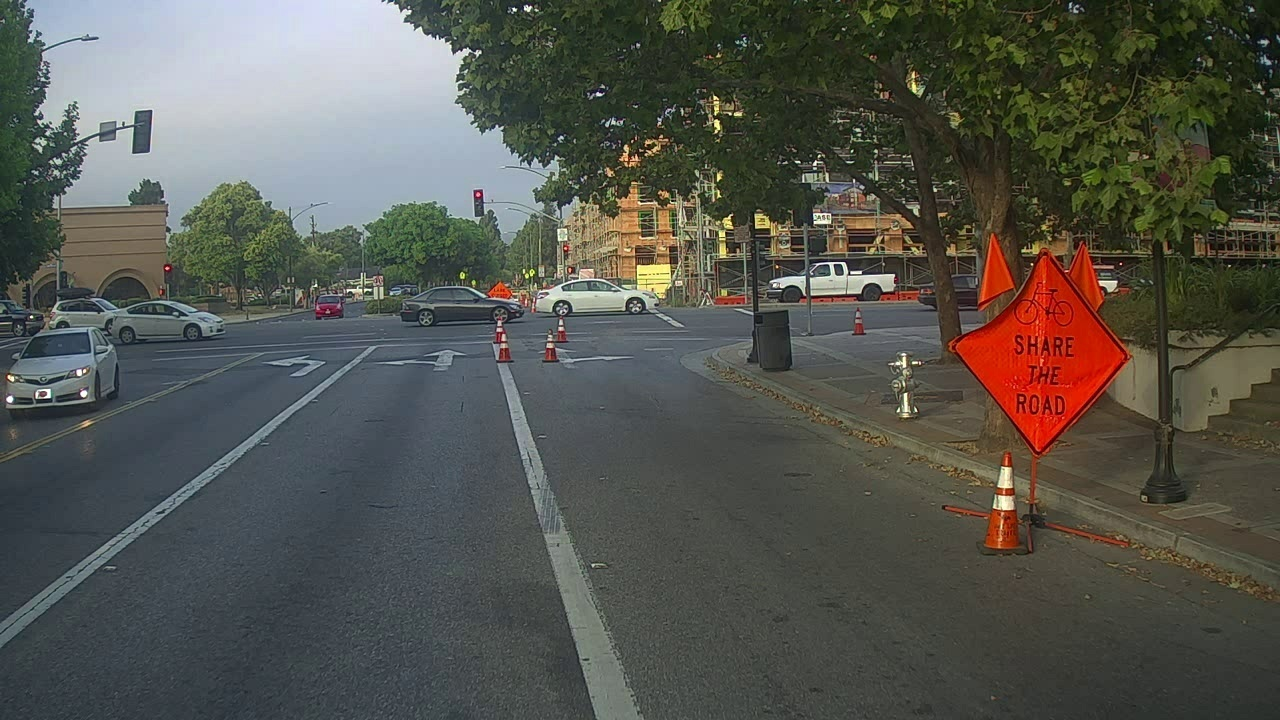

I0403 14:42:57.423174 140618262108032 <ipython-input-21-be03c3b6b2ee>:17] weights loaded
I0403 14:42:57.425770 140618262108032 <ipython-input-21-be03c3b6b2ee>:20] classes loaded
I0403 14:42:57.542857 140618262108032 <ipython-input-21-be03c3b6b2ee>:31] time: 0.10331201553344727
I0403 14:42:57.543824 140618262108032 <ipython-input-21-be03c3b6b2ee>:33] detections:


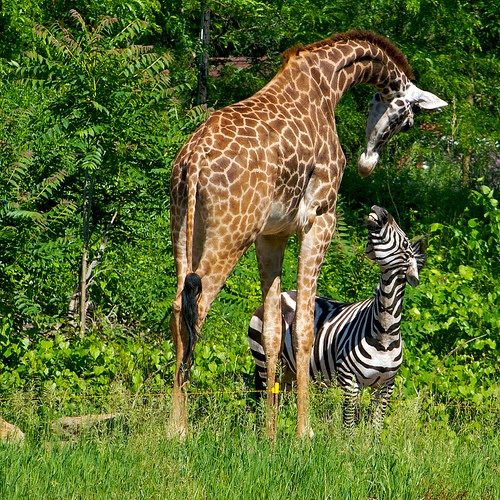

In [23]:
displayFineTunedModelResult('data/test.jpg')
displayFineTunedModelResult('data/street.jpg')
displayFineTunedModelResult('data/0004.jpg')
displayFineTunedModelResult('data/giraffe.jpg')

# since fine tuning had lesser class categories, can observe fewer bounding boxes.